<a href="https://colab.research.google.com/github/richhhuangg/richhhuangg/blob/main/Refactor_of_HW2_2D_Image_Classification_demo_IH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Course 2 : 2D Image Classification**



## Objectives

1. Acquire the procedure of building a image classification ML model from scratch.

2. Understand the concept of neural networks and what does it looks like.

3. Experience the ML model prediction process and output format.

## Abstract
An image classifier is a type of artificial intelligence (AI) system that can analyze an image and categorize it into one of several predefined classes. For example, an image classifier trained to recognize animals might categorize images into classes like "cat," "dog," "bird," etc. In this course,  we use the WM811K dataset (a public wafer defect dataset) for the demo, showing how to train an image classifier from scratch. The content will be divided into three sections.

1. **Image Preprocessing**: The process of preparing images for use in a machine learning model. It involves tasks such as resizing, normalization, and augmentation to make sure the images are in a suitable format and quality for training.
2. **Image Classifier Training**: The phase where a machine learning model learns to recognize patterns in images. During training, the model is fed labeled images (with known categories) and adjusts its internal parameters to minimize errors in its predictions.
3. **Image Classifier Inference (Prediction)**: The phase where the trained model is used to make predictions on new, unseen images. The model outputs its best guess for the category of each image based on what it learned during training.




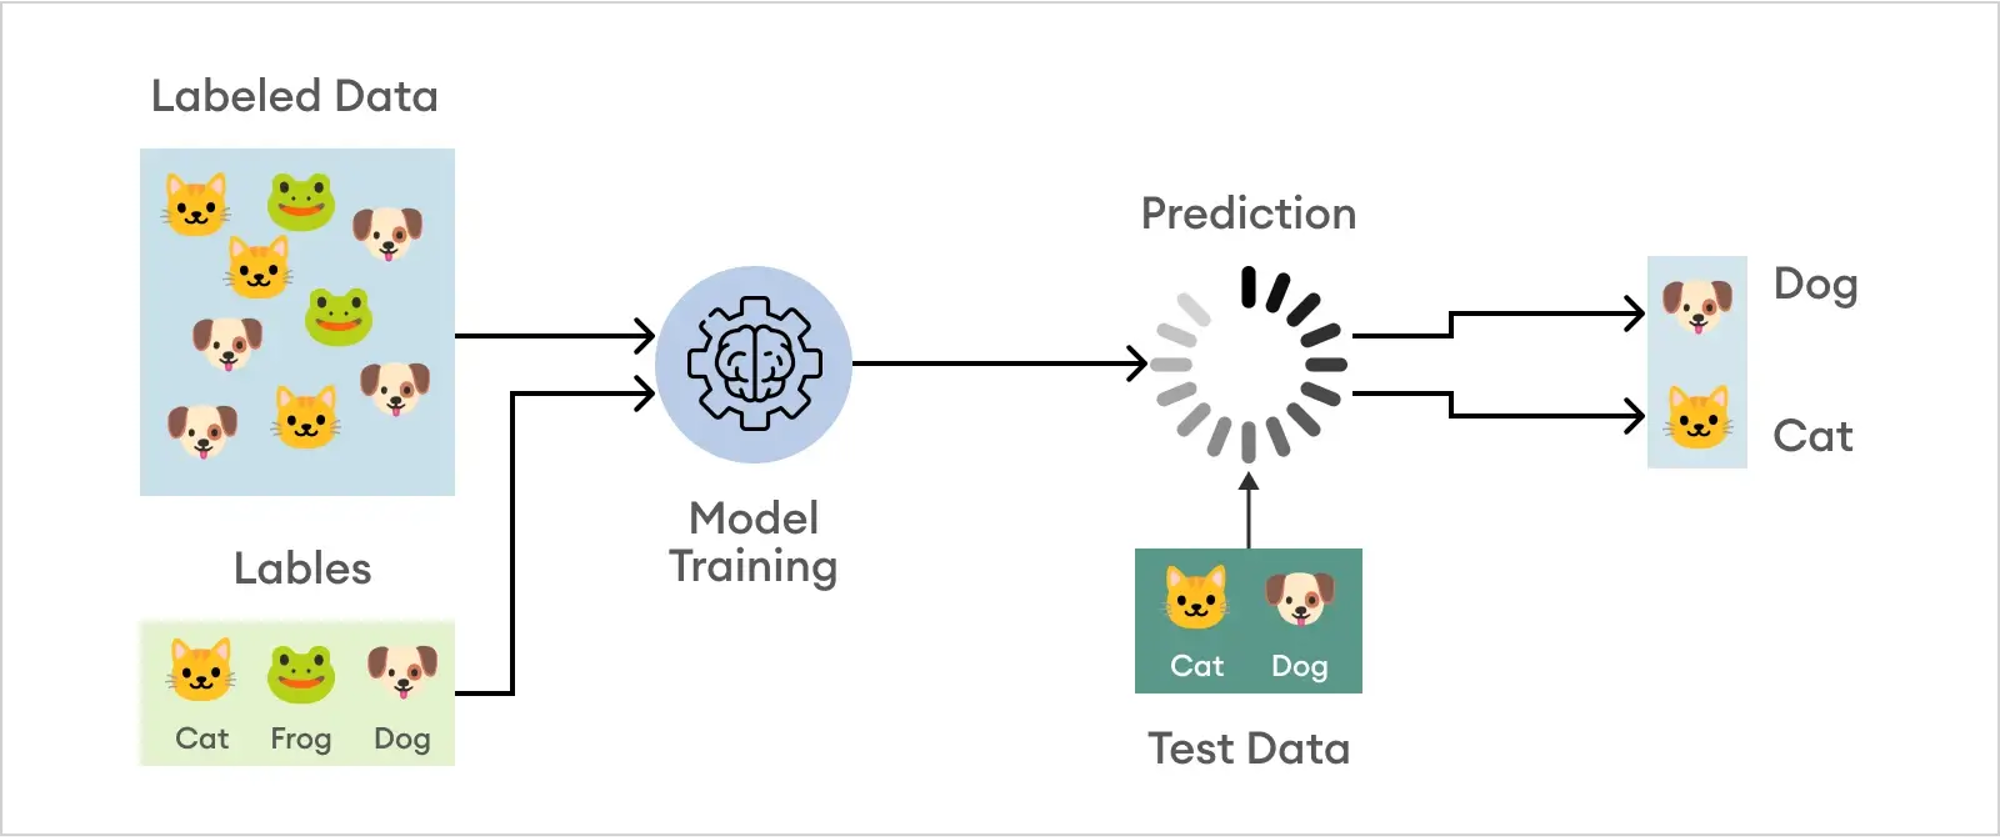

## Prepare Environment

In this section, we primarily focus on setting up the environment required for ML training on Colab. If you plan to implement ML training on your own computer or development environment in the future, the content of this section may not necessarily apply.

### Mount Google Drive
You **MUST** mount your Google Drive so that the  results can be saved on it.

To mount Google Drive, please follow these steps:

1. Run the next cell.
2. Click on "Connect to Google Drive". (There should be a window popup)
3. Sign in your account and give permission

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
root_folder = "/content/drive/MyDrive/2D_Image_Classification"
!mkdir $root_folder
%cd $root_folder

### Activate GPU
Since you will train a model, you **MUST** activate GPU so that this homework can be done in reasonable time

#### **MUST READ**

Colab does **NOT** guarantee the GPU access for free user ([ref](https://research.google.com/colaboratory/faq.html#idle-timeouts)). It is possible you get an message saying "Cannot connect to GPU backend" which means there are no enough GPU resources for you now. When this happens, you may need to **wait for one (or more) day or login different Google account to do the work**.

### Enable GPU

1. Click on "Runtime" (or "執行階段") in the header.
2. Click on "Change runtime type" (or "變更執行階段類型") in the drop menu.
3. Select "T4 GPU" and save. (You can select "A100 GPU" or "V100 GPU" if you have Colab Pro)

### Check GPU Type

In [ ]:
!nvidia-smi

### Import Packages
We import some well-written packages created by others to facilitate the training process.

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

### Fix Random Seeds
There may be some randomness involved in the training process. We fix random seeds to make the result reproducible.

In [ ]:
seed = 5201314
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

## Section 1 : Image Preprocessing
Data preprocessing involves transforming raw images into a format suitable for model training.  Common preprocessing steps include resizing images, normalizing pixel values, data augmentation (such as rotation, flipping, and cropping), and splitting data into training, validation, and test sets. Proper preprocessing can significantly improve model performance and generalization.

In this section, you will learn:
* The normal preprcessing steps when prepare data used to train a ML model.
* Why do we need to split dataset into train/validation/test.
* What is data augmentation.

![](https://drive.google.com/uc?export=view&id=10icVbifreDkpyQQtJGYp4SIf59VcDmfu)

### Download WM811K Dataset

### About Dataset

811,457 wafer maps collected from 46,393 lots in real-world fabrication

Here lists all defects type in this dataset:

Center, Donut, Edge-Loc, Edge-Ring, Loc, Random, Scratch, Near-full, none.

* Source: https://www.kaggle.com/datasets/qingyi/wm811k-wafer-map?resource=download
* Reference Paper: Wu, Ming-Ju, Jyh-Shing R. Jang, and Jui-Long Chen. “Wafer Map Failure Pattern Recognition and Similarity Ranking for Large-Scale Data Sets.” IEEE Transactions on Semiconductor Manufacturing 28, no. 1 (February 2015): 1–12.

In [ ]:
!gdown 15s9mtbMQf7fUZg73tWNFiy9FpHJnh_dy

In [ ]:
!unzip archive.zip

### Load WM811K Dataset

In [ ]:
df = pd.read_pickle("LSWMD.pkl")

In [ ]:
print(df.info())
display(df.head(3))

### Data Cleaning

Data cleaning is essential in machine learning because it ensures the quality and reliability of the data used to train the model. Without clean data, the model can learn incorrect patterns, leading to poor performance and inaccurate predictions. Common issues like missing values, duplicates, and outliers can introduce noise, bias, or errors in the model, making it less effective. By cleaning the data, we help the model to learn from accurate and relevant information, improving its overall accuracy and generalization to new data.

#### Extract label

In [ ]:
# e.g.)[Loc] → Loc　 @failureType, trianTestLabel column
f_squeeze = lambda x: str(np.squeeze(x))
df["failureType"] = df["failureType"].map(f_squeeze)
df["trianTestLabel"] = df["trianTestLabel"].map(f_squeeze)
df.head()

#### Drop the row data with no specified label

In [ ]:
eliminate_list = ['none', '[]']
df_with_label = df.query(f"failureType not in {eliminate_list}")
print(f"{len(df_with_label)}")
print("Label list: ", df_with_label["failureType"].unique())
df_with_label.head(3)

#### Encode categorical label to numerical label

Since our image classifier cannot understand text, we need to convert categorical data into a format that the model can understand : numbers.

In [ ]:
class2idx = {
    'Loc': 0,
    'Edge-Loc': 1,
    'Center': 2,
    'Edge-Ring': 3,
    'Scratch': 4,
    'Random': 5,
    'Near-full': 6,
    'Donut': 7
}
idx2class = {v: k for k, v in class2idx.items()}

print(idx2class)
with open("idx2class.json", "w") as f:
    json.dump(idx2class, f)

# New column → encoded_labels
df_with_label["encoded_labels"] = df_with_label["failureType"].replace(class2idx)

print(df_with_label["encoded_labels"].value_counts())
df_with_label.reset_index(inplace=True, drop=True)
df_with_label.head(3)

### Visualize data

Let's check the data by Visualization.

In [ ]:
df_with_label.head(10)

In [ ]:
idx2class = {v: k for k, v in class2idx.items()}
batch_size = 32
plt.figure(figsize=(12,12))
for i in range(batch_size):
    ax = plt.subplot(4, 8, i+1)
    ax.axis("off")
    ax.imshow(df_with_label["waferMap"][i])
    ax.set_title(f'{idx2class[df_with_label["encoded_labels"][i]]}:{str(df_with_label["encoded_labels"][i])}', fontsize=8)

### Split train, valid, and test set

Splitting a dataset into train, test, and validation sets is essential for evaluating and improving a machine learning model.

* Training Set: This subset is used to train the model. The model learns patterns, features, and relationships from the data here.
* Validation Set: The validation set is used during the training process to tune hyperparameters and make decisions about model architecture. It helps in preventing overfitting by providing feedback on how well the model generalizes to unseen data. This allows you to adjust the model before final testing.
* Test Set: After the model is fully trained and tuned, the test set is used to evaluate its final performance. It acts as a proxy for how the model will perform on real-world, unseen data. The test set is never used during training or validation to ensure an unbiased evaluation.

By splitting the data in this way, you ensure that the model is trained effectively, its hyperparameters are tuned correctly, and its final performance is assessed accurately without data leakage or overfitting.

In [ ]:
train_data_length = int(0.8*len(df_with_label))  # training data for 80% of all data
df_with_label = df_with_label.sample(frac=1, random_state=2)
df_train, df_test = df_with_label[:train_data_length], df_with_label[train_data_length:]
df_train.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

train_data_length = int(0.7*len(df_train))  # Again, split the train data: train ⇨ train & val
df_train, df_val = df_train[:train_data_length], df_train[train_data_length:]
print(f"training: {len(df_train)}, val: {len(df_val)}, test: {len(df_test)}, (all: {len(df_with_label)})")

# This aims to save the data into your environment.
df_train.to_pickle("dataset_train.pickle")
df_val.to_pickle("dataset_val.pickle")
df_test.to_pickle("dataset_test.pickle")
print(os.listdir())

### Data Augmentation
Data augmentation in the context of 2D image classification refers to a set of techniques used to artificially expand the size and improve the diversity of a training dataset by applying various transformations to the original images. The primary goal is to make the model more robust and generalizable to new, unseen data by exposing it to a wider variety of images during training.

Here are some common data augmentation techniques:

* **Rotation**
: Rotating images by a certain angle (e.g., -30 to +30 degrees). This helps the model become invariant to the orientation of objects in the images.
* **Translation**
: Shifting images horizontally or vertically. This ensures that the model can recognize objects regardless of their position within the image frame.
* **Scaling**
: Zooming in or out of images. This helps the model to understand objects at different scales.
* **Flipping**
: Horizontally or vertically flipping images. Horizontal flipping is common for natural images, while vertical flipping might be used less frequently depending on the context.
* **Cropping**
: Randomly cropping parts of the image and resizing them to the original size. This helps the model focus on different parts of the image and improves its ability to recognize partial views of objects.
* **Color Jittering**
: Randomly changing the brightness, contrast, saturation, and hue of the images. This can help the model become invariant to lighting conditions and color variations.
* **Adding Noise**
: Introducing random noise into the images. This can make the model more robust to noisy real-world data.
* **Gaussian Blurring**
: Applying Gaussian blur to smooth images. This can help the model generalize better by learning to recognize less sharp images.
* **Elastic Transformations**
: Applying random elastic distortions to the images to simulate deformations. This is particularly useful for recognizing objects that might be deformed or occluded.
* **Cutout**
: Randomly masking out square regions of the image. This technique forces the model to focus on the surrounding context rather than relying too heavily on specific features.
* **Mixup**
: Combining two imag
es and their labels to create a new training example. This encourages the model to learn more generalized features.
* **Random Erasing**
: Similar to cutout, but the masked regions can be of varying shapes and sizes. This also helps in making the model less sensitive to specific parts of the image.

Data augmentation can be performed offline (before training) or online (on-the-fly during training). Online augmentation is often preferred because it generates a virtually infinite variety of images, which helps prevent overfitting and improves the model's ability to generalize.

By employing these techniques, you can significantly improve the performance of your image classification model, especially when working with limited datasets.


![](https://miro.medium.com/max/1400/0*0Je9h2iT9m7ribFJ.png)

#### Test Transform

Normally, We don't need augmentations in testing and validation.

All we need here is to resize the PIL image and transform it into Tensor.

In [ ]:
test_tfm = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

#### Train Transform

Because wafermap is round. Let's try flipping and rotation.

Other transforms example: https://pytorch.org/vision/stable/transforms.html

In [ ]:
train_tfm = transforms.Compose([
    transforms.ToPILImage(),
    # Resize the image into a fixed shape (height = width = 64)
    transforms.Resize((64, 64)),

    # TODO: You may add some transforms here.
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation((-180, 180)),

    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

### Dataset
We are using PyTorch to implement the model. PyTorch defines the Dataset class to handle dataset operations, so we need to inherit from the Dataset class and override the "__getitem__" method to facilitate the subsequent reading of images and labels.

In [ ]:
class WafermapDataset(Dataset):
    def __init__(self, dataset_path, transforms = test_tfm):
        super(WafermapDataset, self).__init__()

        self.transforms = transforms
        df = pd.read_pickle(dataset_path).reset_index()
        self.labels = df["encoded_labels"]
        self.wafer_maps = df["waferMap"]
        del df

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        wafermap, label = self.wafer_maps[index], self.labels[index]
        wafermap = self.transforms(wafermap)
        return wafermap, label


## Section 2 : Image Classifier Training

Next, we will begin training our image classifier. Training an ML model is essentially a process of continuous optimization (with the goal of reducing training loss). During this process, the dataset is repeatedly read, and the model's weights are continuously adjusted to achieve convergence.

In this section, you will learn:
* What an image classifier really looks like.
* What parameters we use to train an image classifier.
* Observe the training procedure that make loss converge.

### Convolutional Neural Networks (CNNs)

CNNs are a specialized type of neural network designed specifically for processing structured grid data like images. They have proven exceptionally effective for tasks such as image classification, object detection, and more.

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*lbDXL0IuitCRz4mpZ7MmfQ.png)

Here's a breakdown of the key components and concepts:

#### **Convolutional Layers**
* **Filters/Kernels**: These are small matrices that slide over the input image to detect features such as edges, textures, and more complex patterns as you go deeper into the network.
* **Convolution Operation**: The filter convolves (slides) across the image, performing element-wise multiplication and summation to produce a feature map.
* **Stride**: This defines the number of pixels by which the filter moves at each step. A stride of 1 means the filter moves one pixel at a time.
* **Padding**: Sometimes, zero-padding is added around the border of the image to control the spatial dimensions of the output feature map.

![](https://vitalflux.com/wp-content/uploads/2021/11/Input-image-along-with-convolutional-layer.png)

#### **Pooling Layers**
Pooling layers are used to reduce the spatial dimensions (width and height) of the feature maps, thereby reducing computational complexity and helping to achieve translation invariance.
* **Max Pooling**: Takes the maximum value in each patch of the feature map.
* **Average Pooling**: Takes the average value in each patch.

![](https://production-media.paperswithcode.com/methods/MaxpoolSample2.png)

#### **Fully Connected Layers**
After several convolutional and pooling layers, the high-level reasoning in the neural network is done via fully connected layers. These layers take the flattened output from the previous layers and produce the final classification output.

![](https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/74_blog_image_2.png)

#### **Batch Normalization**
Batch normalization is a technique used in training deep neural networks to improve performance and stability. It involves normalizing the inputs of each layer by adjusting and scaling the activations.

#### **Activation Functions**
After convolution, an activation function like ReLU (Rectified Linear Unit) is applied to introduce non-linearity into the model, allowing it to learn more complex patterns.

#### **Dropout**
Dropout is a regularization technique used to prevent overfitting. During training, dropout randomly sets a fraction of the input units to zero at each update.


### Architecture of a Typical CNN
1. **Input Layer**: Takes the raw image data.
2. **Convolutional Layer(s)**: Apply multiple filters to detect features.
3. **Activation Function (ReLU)**: Introduces non-linearity.
4. **Pooling Layer(s)**: Reduces dimensionality.
5. **Fully Connected Layer(s)**: Computes the final output.
6. **Output Layer**: Produces the class probabilities.

### Advantages of CNNs
* **Parameter Sharing**: Filters are reused across the entire input, reducing the number of parameters.
* **Local Connectivity**: Neurons in a layer are connected only to a local region of the input, capturing spatial hierarchies.
* **Translation Invariance**: Pooling layers help make the model invariant to translations of the input image.

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input shape [1, 64, 64]

        # Convolutional Neural Network (CNN)
        # Extracting meaningful features from the images that can be used for classification
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),    # [64, 64, 64]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Conv2d(64, 64, 3, 1, 1),    # [64, 64, 64]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),        # [64, 32, 32]
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, 3, 1, 1),    # [128, 32, 32]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Conv2d(128, 128, 3, 1, 1),    # [128, 32, 32]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),        # [128, 16, 16]
            nn.Dropout(0.3),

            nn.Conv2d(128, 256, 3, 1, 1),    # [256, 16, 16]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Conv2d(256, 256, 3, 1, 1),    # [256, 16, 16]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),        # [256, 8, 8]
            nn.Dropout(0.3),

            nn.Conv2d(256, 512, 3, 1, 1),    # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Conv2d(512, 512, 3, 1, 1),    # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),        # [512, 4, 4]
            nn.Dropout(0.3),
        )

        # Fully Connected Network (FCN)
        # Using the extracted features, the model predicts the class of the image.
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 8)
        )

    # data flow
    def forward(self, x):
        # extract feature map from input image x.
        out = self.cnn(x)
        # flatten feature map to 1D image embedding
        out = out.view(out.size()[0], -1)
        # using image feature embedding and predict the class
        return self.fc(out)

### Training

#### Hyperparameters
Hyperparameters are the parameters of a machine learning model that are set before the training process begins and remain constant during training. They significantly influence the performance and efficiency of the model. Unlike model parameters, which are learned from the training data, hyperparameters are set manually and often require experimentation to optimize.

##### **Batch Size**
* The number of training examples used in one iteration of the training process.
* A smaller batch size provides a more accurate estimate of the gradient, but can be computationally expensive. A larger batch size can speed up training but might result in less accurate gradient estimates. There is often a trade-off between training time and model performance.

##### **Epoch**
* One complete pass through the entire training dataset
* The number of epochs determines how many times the learning algorithm works through the entire training set. Too few epochs can lead to underfitting, while too many can lead to overfitting. It's crucial to find a balance.

##### **Patience**
* A parameter used in early stopping to specify the number of epochs with no improvement after which training will be stopped.
* It helps to prevent overfitting by stopping the training process once the model's performance on a validation set stops improving. A higher patience value allows the model more time to improve, while a lower value stops training sooner.

#### **Criterion (Loss Function)**
* A function that measures the difference between the predicted output and the actual output.
* The choice of criterion affects how the model updates its parameters. Common loss functions include Mean Squared Error (MSE) for regression tasks and Cross-Entropy Loss for classification tasks.

#### **Optimizer**
* An algorithm or method used to adjust the weights of the neural network to minimize the loss function.
* Different optimizers have different strategies for updating weights and can significantly affect the training dynamics. Common optimizers include Stochastic Gradient Descent (SGD), Adam, RMSprop, and others.

##### **Learning Rate**
* A hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated.
* A higher learning rate can speed up training but might cause the model to converge to a suboptimal solution. A lower learning rate usually results in more stable training but requires more epochs to converge.

##### **Weight Decay**
* A regularization technique that adds a penalty to the loss function proportional to the magnitude of the weights.
* Weight decay helps prevent overfitting by discouraging the model from fitting too closely to the training data. It effectively reduces the complexity of the model by penalizing large weights.

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)

# The number of batch size.
batch_size = 64

# The number of training epochs.
n_epochs = 100

# If no improvement in 'patience' epochs, early stop.
patience = 6

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

#### Dataloader for Training

In [ ]:
# Construct train and valid datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = WafermapDataset(dataset_path="dataset_train.pickle", transforms=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = WafermapDataset(dataset_path="dataset_val.pickle")
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

print(len(train_set))
print(len(valid_set))

#### Training Process

The core of the training process, usually consisting of the following steps, repeated for a number of epochs or until convergence:

1. **Epoch Loop**: Repeat for a predetermined number of epochs (one epoch = one full pass through the entire dataset).
2. **Batch Loop**: For each epoch, iterate over the dataset in batches.
3. **Forward Pass**: Pass the input data batch through the model to get predictions.
4. **Compute Loss**: Compute the loss between the model's predictions and the actual target values.
5. **Backward Pass**: Compute gradients of the loss with respect to the model parameters via backpropagation.
6. **Parameter Update**: Update the model parameters using the optimizer.
7. **Zero Gradients**: Clear the gradients to prevent accumulation from multiple backward passes.

#### Monitoring and Evaluation
* **Validation**: Periodically evaluate the model on a validation set to monitor performance and detect overfitting.
* **Logging**: Keep track of metrics like training loss, validation loss, accuracy, etc.
* **Checkpointing**: Save the model parameters at regular intervals or when performance improves.

![](https://drive.google.com/uc?export=view&id=1NiprzNGMBNFSG9fh2aNyL-lNcCL__bIh)

In [ ]:
# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        # print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # update logs
    if valid_acc > best_acc:
        with open(f"log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

### Testing

#### Dataloader for Testing

In [ ]:
# Construct test datasets.
# The argument "loader" tells how torchvision reads the data.
test_set = WafermapDataset(dataset_path="dataset_test.pickle")
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

#### Load best model

In [ ]:
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(f"best.ckpt"))
model_best.eval()

#### Predict Test Result

In [ ]:
with torch.no_grad():
    test_accs = []
    for batch in tqdm(test_loader):
        imgs, labels = batch
        logits = model(imgs.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        test_accs.append(acc)

    test_acc = sum(test_accs) / len(test_accs)

    # Print the information.
    print(f"Test Accuracy = {test_acc*100:.3f}%")

## Section 3 : Image Classifier Inference


After training the image classifier, the next step is to use it (inference). When we input an image to be predicted into the model, the model will generate an array where each element represents the predicted probability for each class. We need to select the class with the highest probability to obtain the final prediction result from the model.

In this section, you will learn:
* The procedure that we use image classifier to classificate an image.
* Observe the output format of image classifier.

![](https://drive.google.com/uc?export=view&id=1ZUhqP-PFpLu3auTxa8J9GPlqHB0-TWah)

### Load best model

In [ ]:
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(f"best.ckpt"))
model_best.eval()

### Load dictionary

In [ ]:
with open("idx2class.json", "r") as f:
    idx2class = json.load(f)
print(idx2class)

### Load image

In [ ]:
df = pd.read_pickle("dataset_test.pickle").reset_index()
wafer_map = df["waferMap"][0]
lable = df["failureType"][0]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(wafer_map)
ax.set_title(f'Correct label : {lable}')

### Test transform

In [ ]:
test_tfm = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

### Predict

Let's see the original output of image classifier and how we transform it into final output

In [ ]:
with torch.no_grad():
    # image preprocess
    wafer_map = test_tfm(wafer_map)
    # put image to GPU
    img = wafer_map.to(device).unsqueeze(0)
    # predict probability of each class
    logits = model_best(img)

    print(f"the original output from ML model is an array like :\n{logits}")

choose the element with highest probability as the final output

In [ ]:
# get largest probability class
idx = logits.argmax(dim=-1).cpu().numpy()
# translate index to class name
result = idx2class[str(int(idx))]

print(f"We select the one with the highest probability as the final output.\nThe final label predicted by ML is : {result}")

## Creat PDF for upload as homework

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#install tools used to create .pdf with correct format
!sudo apt-get -y install jq weasyprint

In [ ]:
#create .pdf and save to the path : /content/drive/MyDrive/Colab Notebooks/
#please modify "your_notebook_name" to your file name
your_notebook_name = "your_notebook_name"
notebook_path = f"/content/drive/MyDrive/Colab\ Notebooks/{your_notebook_name}.ipynb"
pdf_path = f"/content/drive/MyDrive/Colab\ Notebooks/{your_notebook_name}.pdf"

!cp $notebook_path "/content/notebook.ipynb"
!jq -M 'del(.metadata.widgets)' "/content/notebook.ipynb" > "/content/notebook_fixed.ipynb"
!jupyter nbconvert --to html "/content/notebook_fixed.ipynb"
!weasyprint -e utf-8 "/content/notebook_fixed.html" "/content/notebook_fixed.pdf"
!cp "/content/notebook_fixed.pdf" $pdf_path